In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context
import matplotlib.colors as clr


def save_df_to_text(obj, filename):
    obj.to_csv(filename, sep='\t')


In [2]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [3]:
sys.path.append('../../Code/')
from utils import read_dataset_log

In [4]:
! pwd

/data/srlab1/TCAT/Analysis/TCAT


In [5]:
figdir = '../../Figures/Components'

In [6]:
gep_info = read_dataset_log('cGEP_Name')
gep_info.index = gep_info['cGep_Name']
gep_info.head()
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

In [7]:
oldname_map = dict(zip(gep_info['Old_Short_Name'], gep_info['Short_Name']))

In [8]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params = params[params['dataset_type']=='discovery']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [9]:
cgep_params = read_dataset_log('cGEP Paths').iloc[0,:]
cgep_params

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
reference_fn                                 /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
renamed_ref_fn                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data

In [10]:
usage_all = {}
meta_dict = {}
# usage = pd.DataFrame()
meta = pd.DataFrame()

for dataset in params.index:
    usage_ds = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage_all[dataset] = usage_ds
    
    meta_ds = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
    meta_dict[dataset] = meta_ds
    
    meta_ds = pd.DataFrame({'cell': meta_dict[dataset].index,
                   'cluster': meta_dict[dataset][params.loc[dataset, 'cluster_col']],
                    'dataset': dataset}, 
                   index = meta_dict[dataset].index)
    meta = pd.concat([meta, meta_ds])


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
usage = pd.concat(usage_all.values())
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

In [12]:
meta.shape, usage.shape

((1709860, 3), (1709860, 52))

In [13]:
meta = meta.loc[usage.index, :]

In [14]:
usage.columns

Index(['CellCycle-G2M', 'Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC',
       'gdT', 'CellCycle-S', 'Cytotoxic', 'Doublet-Platelet', 'NME1/FABP5',
       'Th22', 'MAIT', 'CellCycle-Late-S', 'Cytoskeleton', 'Heatshock',
       'Multi-Cytokine', 'TEMRA', 'Doublet-Myeloid', 'Metallothionein',
       'CD4-CM', 'IEG', 'CD8-EM', 'IEG2', 'CD4-Naive', 'Treg', 'Th17-Resting',
       'Poor-Quality', 'CD8-Naive', 'RGCC/MYADM', 'TIMD4/TIM3',
       'Doublet-Plasmablast', 'BCL2/FAM13A', 'IL10/IL19', 'Th2-Activated',
       'Th2-Resting', 'ICOS/CD38', 'Doublet-Bcell', 'Th1-Like', 'CTLA4/CD38',
       'CD8-Trm', 'Th17-Activated', 'Tfh-2', 'OX40/EBI3', 'CD172a/MERTK',
       'IEG3', 'Doublet-Fibroblast', 'SOX4/TOX2', 'CD40LG/TXNIP', 'Tph',
       'Exhaustion', 'Tfh-1'],
      dtype='object')

In [15]:
cc_geps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']
lineage_geps = list(gep_info[gep_info['Class']=='Lineage']['Short_Name'].values)

In [46]:
doublets_geps = list(gep_info.loc[gep_info['Class'] == 'Doublet Lineage', 'Short_Name'].dropna().values)
doublets_geps

['Doublet-RBC',
 'Doublet-Platelet',
 'Doublet-Plasmablast',
 'Doublet-Bcell',
 'Doublet-Myeloid',
 'Doublet-Fibroblast']

In [16]:
lineage_geps

['CD8-EM',
 'MAIT',
 'Treg',
 'CD4-Naive',
 'TEMRA',
 'CD4-CM',
 'gdT',
 'Th22',
 'Th17-Resting',
 'Th2-Resting',
 'Th1-Like',
 'CD8-Naive',
 'CD8-Trm',
 'Tfh-2',
 'Tph',
 'Tfh-1']

In [17]:
ds_res_fn = '/data/srlab1/TCAT/Data/TCAT/Proliferation/Proliferation.AllDataset.PerSamplePairedTtest.tsv'
ds_res = pd.read_csv(ds_res_fn, index_col = 0, sep = '\t')

meta_res_fn = '/data/srlab1/TCAT/Data/TCAT/Proliferation/Proliferation.AllDataset.PerSamplePairedTtest.Metaanalysis.tsv'
meta_res = pd.read_csv(meta_res_fn, index_col = 0, sep = '\t')

# ds_res['GEP'] = ds_res['GEP'].map(oldname_map)
# meta_res.index = meta_res.index.map(oldname_map)

In [18]:
cc_assoc_geps = list(meta_res['P'][(meta_res['P']< 0.05) & (meta_res['Mean_Log2_Ratio']>0)].index)
cc_assoc_geps

['NME1/FABP5',
 'TIMD4/TIM3',
 'HLA',
 'Exhaustion',
 'Cytoskeleton',
 'ICOS/CD38',
 'CTLA4/CD38',
 'OX40/EBI3',
 'Th17-Activated',
 'Metallothionein',
 'IL10/IL19',
 'Tph']

# Heatmap of proliferation by lineage + prolif-associated GEPs

In [19]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap


In [20]:
dataset = 'COMBAT'


In [21]:
meta_dict[dataset]['Annotation_cluster_name'].unique()

array(['CD8.TEMRA.1', 'CD4.Th', 'CD8.TEM', 'CD4.NAIVE.2', 'CD4.NAIVE.1',
       'MAIT.CD8.CCL5.cytox_lo.1', 'CD8.TEMRA.4', 'CD8.NAIVE.1',
       'CD8.TEM.KLRB1', 'CD4.TREG.CCR4hi', 'CD4.TEFF.TCF7',
       'CD4.Th.CCR4.CCR10', 'CD4.TEFF.prolif.1', 'CD4.Th1.1', 'CD4.Th17',
       'CD4.TEMRA.KLRB1', 'CD4.TREG', 'CD8.TEMRA.3', 'CD4.TEFF.GZMK',
       'CD4.Th.mitohi', 'CD4.Th.IFN.resp', 'CD4.Th.CXCR5.KLRB1',
       'DN.CCL5.cytox_hi.1', 'DP.1', 'CD8.TCM.CCL5.1',
       'GDT.VD1.CCL5.cytox_lo.1', 'DN.CCL5.cytox_hi.2', 'CD8.TEFF.1',
       'CD8.TEMRA.mitohi.1', 'CD8.TCM.mitohi', 'CD8.NAIVE.2',
       'CD4.Th1/Th17', 'CD8.TEMRA.2', 'GDT.VD1.CCL5.cytox_hi.1',
       'CD8.TEFF.prolif.1', 'CD8.NAIVE.3', 'CD8.TEMRA.mitohi.3',
       'DP.CCL5/GZM_lo.1', 'CD8.TEFF.prolif.2',
       'DP.CCL5.cytox_lo.prolif.1', 'CD4.TEM.mitohi.1', 'CD8.TCM.CCR6',
       'DN.CCL5.cytox_lo.1', 'CD4.TEM', 'CD8.TCM.CCR10',
       'GDT.VD2.VG9.CCL5.cytox_hi.1', 'GDT.VD1.VG9.CCL5.cytox_hi.4',
       'DP.CCL5/GZM_lo.2', 'CD

In [22]:
ct = pd.crosstab(meta_dict[dataset]['Annotation_minor_subset'], 
           meta_dict[dataset]['Annotation_cluster_name'])

In [23]:
ct.loc[ct.index.str.contains('prolif'), 
       ct.columns.str.contains('prolif')]

Annotation_cluster_name,CD4.TEFF.prolif.1,CD4.TEFF.prolif.2,CD4.TEFF.prolif.3,CD4.TEFF.prolif.GZMB.1,CD4.TEFF.prolif.GZMB.2,CD4.TEFF.prolif.MKI67lo,CD8.TEFF.prolif.1,CD8.TEFF.prolif.2,CD8.TEFF.prolif.3,CD8.TEFF.prolif.4,...,GDT.VD1.VG9.CCL5.cytox_hi.prolif.3,GDT.VD1.VG9.CCL5.cytox_hi.prolif.4,GDT.VD1.VG9.CCL5.cytox_hi.prolif.5,GDT.VD2.VG9.CCL5.cytox_hi.prolif.1,GDT.VD2.VG9.CCL5.cytox_hi.prolif.2,GDT.VD2.VG9.CCL5.cytox_hi.prolif.3,GDT.VD2.VG9.CCL5.cytox_hi.prolif.4,MAIT.CD8.CCL5.cytox_lo.prolif.1,MAIT.CD8.CCL5.cytox_lo.prolif.2,MAIT.CD8.CCL5.cytox_lo.prolif.3
Annotation_minor_subset,,,,,,,,,,,,,,,,,,,,,
CD4.TEFF.prolif,1893,1549,703,62,26,528,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CD8.TEFF.prolif,0,0,0,0,0,0,2689,1329,726,90,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ct.columns[ct.columns.str.contains('prolif')]

Index(['CD4.TEFF.prolif.1', 'CD4.TEFF.prolif.2', 'CD4.TEFF.prolif.3',
       'CD4.TEFF.prolif.GZMB.1', 'CD4.TEFF.prolif.GZMB.2',
       'CD4.TEFF.prolif.MKI67lo', 'CD8.TEFF.prolif.1', 'CD8.TEFF.prolif.2',
       'CD8.TEFF.prolif.3', 'CD8.TEFF.prolif.4', 'CD8.TEFF.prolif.5',
       'DN.CCL5.cytox_hi.prolif', 'DN.CCL5.cytox_lo.prolif.1',
       'DN.CCL5.cytox_lo.prolif.2', 'DP.CCL5.cytox_lo.prolif.1',
       'DP.CCL5.cytox_lo.prolif.2', 'DP.CCL5.cytox_lo.prolif.3',
       'DP.CCL5.cytox_lo.prolif.4', 'DP.CCL5.cytox_lo.prolif.5',
       'GDT.VD1.CCL5.cytox_hi.prolif.1', 'GDT.VD1.CCL5.cytox_hi.prolif.2',
       'GDT.VD1.CCL5.cytox_hi.prolif.3', 'GDT.VD1.CCL5.cytox_hi.prolif.4',
       'GDT.VD1.VG9.CCL5.cytox_hi.prolif.1',
       'GDT.VD1.VG9.CCL5.cytox_hi.prolif.2',
       'GDT.VD1.VG9.CCL5.cytox_hi.prolif.3',
       'GDT.VD1.VG9.CCL5.cytox_hi.prolif.4',
       'GDT.VD1.VG9.CCL5.cytox_hi.prolif.5',
       'GDT.VD2.VG9.CCL5.cytox_hi.prolif.1',
       'GDT.VD2.VG9.CCL5.cytox_hi.prolif.2',
  

In [25]:
dataset = 'COMBAT'
cluster_labels_combat = meta[meta['dataset']==dataset]['cluster'].copy()
cluster_labels_combat[-cluster_labels_combat.str.contains('prolif', na=False)] = 'Other'
cluster_labels_combat.name = None

In [26]:
cluster_labels_combat.value_counts()

Other              389945
CD8.TEFF.prolif      4893
CD4.TEFF.prolif      4761
dtype: int64

In [27]:
cluster_labels_combat_order = ['CD8.TEFF.prolif', 'CD4.TEFF.prolif', 'Other']
cmap_clusters_combat = dict(zip(cluster_labels_combat_order, range(0, len(cluster_labels_combat))))

# rowcolor_cmap_combat = cm.get_cmap('tab20', len(cluster_labels_combat_order))
rowcolor_cmap_combat = LinearSegmentedColormap.from_list('', [cm.get_cmap('tab20b')(1),
                                                             cm.get_cmap('tab20b')(3),
                                                             cm.get_cmap('tab20_r')(5)], N = 3)
cmap_clusters_legend_combat = {clus: rowcolor_cmap_combat(n) for clus, n in cmap_clusters_combat.items()}

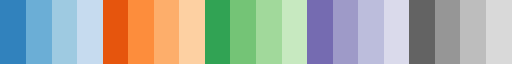

In [28]:
cm.get_cmap('tab20c')

In [29]:
cm.get_cmap('tab20b')(0)

(0.2235294117647059, 0.23137254901960785, 0.4745098039215686, 1.0)

In [30]:
cm.get_cmap('tab20b')(3)

(0.611764705882353, 0.6196078431372549, 0.8705882352941177, 1.0)

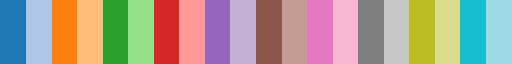

In [31]:
cm.get_cmap('tab20')

In [32]:
threshold = 0.1
# usage_thresholded = usage_norm[cc_geps].sum(axis = 1) > threshold

ind = usage_norm.loc[meta[meta['dataset']==dataset].index, cc_geps].sum(axis = 1) > threshold
label = ind.replace({False:'Cell Cycle\n<= 0.1'})
label.loc[ind] = 'Cell Cycle\n> 0.1'#adata.obs.loc[ind, 'celltype.l2']

In [33]:
usage_cc = (usage_norm.loc[meta[meta['dataset']==dataset].index, :]).copy() #usage.copy()

usage_excl_cc = usage_cc.loc[:, [x for x in usage_cc.columns if x not in cc_geps]]
usage_excl_cc = usage_excl_cc.div(usage_excl_cc.sum(axis=1), axis=0)
print(usage_excl_cc.shape)
usage_excl_cc = usage_excl_cc.dropna() # Excldue cells with 0 usage of GEPs other than cc_geps
print(usage_excl_cc.shape)
usage_cc = usage_cc.loc[usage_excl_cc.index, :]


(399599, 49)
(399599, 49)


In [47]:
['Doublet-RBC',
 'Doublet-Platelet',
 'Doublet-Plasmablast',
 'Doublet-Bcell',
 'Doublet-Myeloid',
 'Doublet-Fibroblast']

['Doublet-RBC',
 'Doublet-Platelet',
 'Doublet-Plasmablast',
 'Doublet-Bcell',
 'Doublet-Myeloid',
 'Doublet-Fibroblast']

In [64]:
identity_max = usage_excl_cc.loc[:, lineage_geps + ['Doublet-Myeloid']].replace(0, np.nan).idxmax(axis = 1)
usage_to_show = pd.concat([usage_cc[cc_geps], usage_excl_cc], axis=1)
cluster_order = ['Cell Cycle\n> 0.1', 'Cell Cycle\n<= 0.1']
nclusters = len(cluster_order)
vmax = usage_to_show.unstack().quantile(.99)

In [65]:
# # Max lineage after column-normalizing usages_norm
# usage_col_norm = (usage_norm.loc[meta[meta['dataset']==dataset].index, :]).copy()
# usage_col_norm = usage_col_norm.div(usage_col_norm.sum(axis = 0), axis = 1)*100
# identity_max = usage_col_norm.loc[usage_excl_cc.index, lineage_geps].replace(0, np.nan).idxmax(axis = 1)

In [66]:
identity_max.value_counts()

CD4-Naive          148113
CD8-EM              46393
CD8-Naive           33120
Th2-Resting         22653
Th17-Resting        21886
Th1-Like            21246
Treg                18115
TEMRA               17260
Th22                14545
CD4-CM              13085
gdT                 10464
Doublet-Myeloid     10250
MAIT                 8643
CD8-Trm              6449
Tfh-2                2898
Tfh-1                2518
Tph                  1961
dtype: int64

In [74]:
ds_res_fc = ds_res[ds_res['dataset']==dataset].sort_values('logRatio', ascending = False)
ds_res_fc.index = ds_res_fc['GEP']

# Order identity GEPs based on association with Cell Cycle
identitygeporder = list(ds_res_fc[ds_res_fc.index.isin(lineage_geps  + ['Doublet-Myeloid'] )].index)
cc_assoc_gep_order = list(ds_res_fc[ds_res_fc.index.isin(set(cc_assoc_geps).difference(lineage_geps))
                                   ].index)
fullgeporder = cc_geps + identitygeporder + cc_assoc_gep_order[:-2]

In [75]:
cc_assoc_gep_order

['NME1/FABP5',
 'TIMD4/TIM3',
 'CTLA4/CD38',
 'ICOS/CD38',
 'Exhaustion',
 'Th17-Activated',
 'HLA',
 'Cytoskeleton',
 'OX40/EBI3',
 'IL10/IL19',
 'Metallothionein']

In [76]:
fullgeporder

['CellCycle-G2M',
 'CellCycle-S',
 'CellCycle-Late-S',
 'Tph',
 'Tfh-1',
 'Tfh-2',
 'TEMRA',
 'CD8-Trm',
 'Treg',
 'Th22',
 'CD4-CM',
 'gdT',
 'CD8-EM',
 'MAIT',
 'Doublet-Myeloid',
 'Th1-Like',
 'Th2-Resting',
 'Th17-Resting',
 'CD8-Naive',
 'CD4-Naive',
 'NME1/FABP5',
 'TIMD4/TIM3',
 'CTLA4/CD38',
 'ICOS/CD38',
 'Exhaustion',
 'Th17-Activated',
 'HLA',
 'Cytoskeleton',
 'OX40/EBI3']

In [77]:
identitygeporder

['Tph',
 'Tfh-1',
 'Tfh-2',
 'TEMRA',
 'CD8-Trm',
 'Treg',
 'Th22',
 'CD4-CM',
 'gdT',
 'CD8-EM',
 'MAIT',
 'Doublet-Myeloid',
 'Th1-Like',
 'Th2-Resting',
 'Th17-Resting',
 'CD8-Naive',
 'CD4-Naive']

In [78]:
legend_fontsize = 7

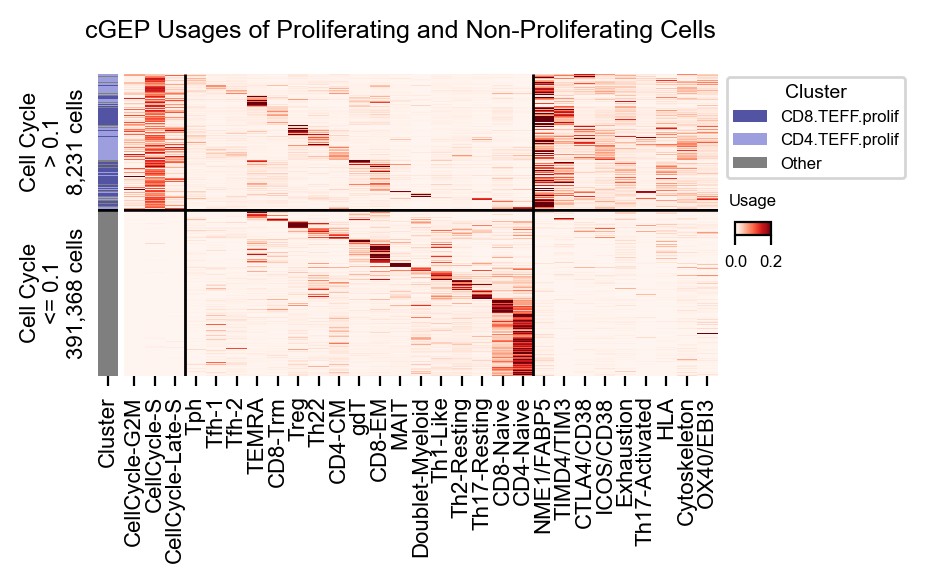

In [80]:
hspace = 0.01
nrows = 2
ncols = 2
vmin = 0


fig = plt.figure(constrained_layout=False, dpi= 200, figsize=(4,2)) 
axes = []
gs = fig.add_gridspec(nrows, ncols, 
                      wspace=0.02, hspace=0, 
                      width_ratios = [1, len(fullgeporder)],
                     height_ratios = [4, 5])

for i in range(nrows):
    rowax = []
    for j in range(ncols):
        if i != (nrows-1):
            rowax.append(fig.add_subplot(gs[i, j]))
        else:
            rowax.append(fig.add_subplot(gs[i, j]))
    axes.append(rowax)
axes = np.array(axes)


for i,c in enumerate(cluster_order):
    # i += 1
    usage_cluster = usage_to_show.loc[label==c, fullgeporder]
    identity_max_cluster = identity_max.loc[usage_cluster.index]
    
    cellorder = []
    for g in identitygeporder:
        cellorder += list(identity_max_cluster.loc[identity_max_cluster==g].sort_values(ascending=False).index)
    cellorder += list(identity_max_cluster[identity_max_cluster.isna()].index)

    usage_cluster = usage_cluster.loc[cellorder, :]
    
    # Plot colorbar corresponding to clustering
    cluster_label = cluster_labels_combat[cellorder] 
    sns.heatmap(pd.DataFrame(cluster_label.map(cmap_clusters_combat), 
                             columns = ['Cluster']), ax=axes[i, 0], 
                vmin=0, vmax=2, 
                yticklabels=False, xticklabels=(i==nrows-1), cbar = False, 
                cmap = rowcolor_cmap_combat, rasterized=True)
    axes[i, 0].tick_params(axis = 'x', labelrotation = 90, labelsize = tick_fontsize)
    
    if i != (nrows-1):
        sns.heatmap(usage_cluster, ax=axes[i, 1], vmin=vmin, vmax=vmax, yticklabels=False, xticklabels=False,
                   cbar = False, cmap = "Reds", rasterized=True)
    else:
        sns.heatmap(usage_cluster, ax=axes[i, 1], vmin=vmin, vmax=vmax, yticklabels=False, 
                    xticklabels=pd.Index(usage_cluster.columns), 
                   cbar = False, cmap = "Reds", rasterized=True)
        axes[i, 1].tick_params(axis = 'x', labelsize = tick_fontsize)
    
    axes[i, 1].vlines(ymin = 0, ymax = usage_cluster.shape[0], x = len(cc_geps),
                  linestyles = '-', colors = 'black', linewidth = 1)
    axes[i, 1].vlines(ymin = 0, ymax = usage_cluster.shape[0], x = len(cc_geps)+len(lineage_geps)+1,
                  linestyles = '-', colors = 'black', linewidth = 1)
    axes[i, 0].set_ylabel(c + '\n%s cells' % f"{len(cellorder):,}", fontsize = label_fontsize-2)
    
    if i==nrows-1:
        axes[i, 0].hlines(xmin = 0, xmax = usage_cluster.shape[1], y = 0,
                      linestyles = '-', colors = 'black', linewidth = 2)
        axes[i, 1].hlines(xmin = 0, xmax = usage_cluster.shape[1], y = 0,
                      linestyles = '-', colors = 'black', linewidth = 2)

cax = axes[1, 1].inset_axes([1.03, -.2, .06, 0.1], transform=axes[0, 1].transAxes)
fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("Reds", as_cmap=True)),
             ax=axes[1, 1], cax=cax, orientation='horizontal')
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Usage', fontsize = legend_fontsize-1)
cax.tick_params(labelsize=legend_fontsize-1)


handles_clusters = [Patch(facecolor = col) for (clus, col) in cmap_clusters_legend_combat.items()]
plt.legend(handles_clusters, cmap_clusters_legend_combat, title='Cluster',
           bbox_to_anchor=(.645, .6, 0.5, 0.15), bbox_transform=plt.gcf().transFigure, 
           loc='lower right', fontsize = legend_fontsize-1, title_fontsize = legend_fontsize)

axes[0, 1].set_title('cGEP Usages of Proliferating and Non-Proliferating Cells', x = .465,
                     y=1.15, fontsize = label_fontsize-1)

plt.savefig(os.path.join(figdir, 'ProliferationLineageHeatmap_COMBAT.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'ProliferationLineageHeatmap_COMBAT.pdf'), bbox_inches="tight")

In [171]:
cmap_clusters_legend_combat

{'CD8.TEFF.prolif': (0.3215686274509804,
  0.32941176470588235,
  0.6392156862745098,
  1.0),
 'CD4.TEFF.prolif': (0.611764705882353,
  0.6196078431372549,
  0.8705882352941177,
  1.0),
 'Other': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0)}

# Proliferative lineages by disease status

In [19]:
results = {}

In [20]:
cc_geps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']
lineage_geps = list(gep_info[gep_info['Class']=='Lineage']['Short_Name'].values)
threshold = 0.1

In [21]:
dataset = 'COMBAT'
pheno_col = 'Covid_or_Healthy'

meta_test = pd.read_csv(params.loc[dataset, 'metadata_fn'].replace('metadata', 'metadata_PhenotypeAssociations'),
                  index_col = 0, sep = '\t')


# Max lineage after column-normalizing usages_norm
usage_dat = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').loc[meta_test.index, :].rename(columns=rename_map)
usage_col_norm = usage_dat.div(usage_dat.sum(axis = 1), axis = 0)
identity_max = usage_col_norm.loc[:, lineage_geps].replace(0, np.nan).idxmax(axis = 1)
prolif = usage_col_norm[cc_geps].sum(axis = 1) > threshold
summary_data = pd.concat([identity_max, prolif.astype(int), meta_test[pheno_col]], axis=1)
summary_data.columns = ['Lineage', 'Proliferating', 'Phenotype']
summary_data['Phenotype'] = summary_data['Phenotype'].replace({'Covid':'Covid-19', 'Healthy_All':'Healthy'})
results[dataset] = summary_data

'''
ct_all = pd.crosstab(identity_max, prolif)
ct_all = ct_all.div(ct_all.sum(axis=1), axis=0)[True]

ind = meta_test[pheno_col] == 'Covid'
ct_covid = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])
ct_covid = ct_covid.div(ct_covid.sum(axis=1), axis=0)[True]

ind = meta_test[pheno_col] == 'Healthy_All'
ct_healthy = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])
ct_healthy = ct_healthy.div(ct_healthy.sum(axis=1), axis=0)[True]

pct_prolif = pd.concat([ct_all, ct_covid, ct_healthy], axis=1)*100
pct_prolif.columns = ['All', 'Covid-19', 'Healthy']

lineage_order = pct_prolif.sort_values(by='Covid-19', ascending=False).index
pct_prolif = pct_prolif.loc[lineage_order, :]
results[dataset] = pct_prolif
'''

"\nct_all = pd.crosstab(identity_max, prolif)\nct_all = ct_all.div(ct_all.sum(axis=1), axis=0)[True]\n\nind = meta_test[pheno_col] == 'Covid'\nct_covid = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])\nct_covid = ct_covid.div(ct_covid.sum(axis=1), axis=0)[True]\n\nind = meta_test[pheno_col] == 'Healthy_All'\nct_healthy = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])\nct_healthy = ct_healthy.div(ct_healthy.sum(axis=1), axis=0)[True]\n\npct_prolif = pd.concat([ct_all, ct_covid, ct_healthy], axis=1)*100\npct_prolif.columns = ['All', 'Covid-19', 'Healthy']\n\nlineage_order = pct_prolif.sort_values(by='Covid-19', ascending=False).index\npct_prolif = pct_prolif.loc[lineage_order, :]\nresults[dataset] = pct_prolif\n"

In [22]:
ct_all = pd.crosstab(identity_max, prolif)
ct_all = ct_all.div(ct_all.sum(axis=1), axis=0)[True]

ind = meta_test[pheno_col] == 'Covid'
ct_covid = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])
ct_covid = ct_covid.div(ct_covid.sum(axis=1), axis=0)[True]
lineage_order = ct_covid.sort_values(ascending=False).index

In [181]:
lineage_order

Index(['Tph', 'CD8-Trm', 'Tfh-2', 'Tfh-1', 'TEMRA', 'CD4-CM', 'Th22', 'CD8-EM',
       'gdT', 'Treg', 'CD8-Naive', 'MAIT', 'Th1-Like', 'Th17-Resting',
       'Th2-Resting', 'CD4-Naive'],
      dtype='object', name='row_0')

In [23]:
dataset = 'UK-Covid'
pheno_col = 'Overall_Status'

meta_test = pd.read_csv(params.loc[dataset, 'metadata_fn'].replace('metadata', 'metadata_PhenotypeAssociations'),
                  index_col = 0, sep = '\t')


# Max lineage after column-normalizing usages_norm
usage_dat = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t').loc[meta_test.index, :].rename(columns=rename_map)
usage_col_norm = usage_dat.div(usage_dat.sum(axis = 1), axis = 0)
identity_max = usage_col_norm.loc[:, lineage_geps].replace(0, np.nan).idxmax(axis = 1)
prolif = usage_col_norm[cc_geps].sum(axis = 1) > threshold
summary_data = pd.concat([identity_max, prolif.astype(int), meta_test[pheno_col]], axis=1)
summary_data.columns = ['Lineage', 'Proliferating', 'Phenotype']
summary_data['Phenotype'] = summary_data['Phenotype'].replace({'Covid':'Covid-19'})
summary_data['Phenotype'] = summary_data['Phenotype'].replace({'Covid':'Covid-19', 'Healthy_All':'Healthy'})

results[dataset] = summary_data

'''
ct_all = pd.crosstab(identity_max, prolif)
ct_all = ct_all.div(ct_all.sum(axis=1), axis=0)[True]

ind = meta_test[pheno_col] == 'Covid'
ct_covid = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])
ct_covid = ct_covid.div(ct_covid.sum(axis=1), axis=0)[True]

ind = meta_test[pheno_col] == 'Healthy_All'
ct_healthy = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])
ct_healthy = ct_healthy.div(ct_healthy.sum(axis=1), axis=0)[True]

pct_prolif = pd.concat([ct_all, ct_covid, ct_healthy], axis=1)*100
pct_prolif.columns = ['All', 'Covid-19', 'Healthy']

pct_prolif = pct_prolif.loc[lineage_order, :]
results[dataset] = pct_prolif
'''

"\nct_all = pd.crosstab(identity_max, prolif)\nct_all = ct_all.div(ct_all.sum(axis=1), axis=0)[True]\n\nind = meta_test[pheno_col] == 'Covid'\nct_covid = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])\nct_covid = ct_covid.div(ct_covid.sum(axis=1), axis=0)[True]\n\nind = meta_test[pheno_col] == 'Healthy_All'\nct_healthy = pd.crosstab(identity_max.loc[ind], prolif.loc[ind])\nct_healthy = ct_healthy.div(ct_healthy.sum(axis=1), axis=0)[True]\n\npct_prolif = pd.concat([ct_all, ct_covid, ct_healthy], axis=1)*100\npct_prolif.columns = ['All', 'Covid-19', 'Healthy']\n\npct_prolif = pct_prolif.loc[lineage_order, :]\nresults[dataset] = pct_prolif\n"

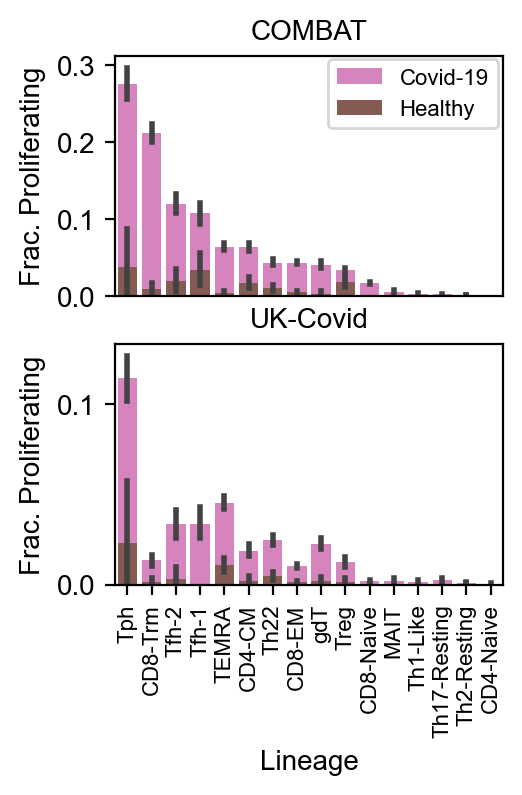

In [183]:
# (fig,axes) = plt.subplots(2, 1, figsize=(2.5,3.5), dpi=200)

# cmap = {'Covid-19': sns.color_palette("tab10")[6], 'Healthy':sns.color_palette("tab10")[5]}
# for i, dataset in enumerate(['COMBAT', 'UK-Covid']):
#     ax = axes[i]
#     pct_prolif = results[dataset]
#     for j, pheno in enumerate(['Covid-19', 'Healthy']):
#         sns.barplot(x='Lineage', y='Proliferating',
#                     ax=ax, order=lineage_order,
#                     palette=cmap, hue='Phenotype', errwidth=2,
#                     data=results[dataset].loc[results[dataset]['Phenotype']==pheno, :])
        
#         #ax.bar(x = lineage_order, height = pct_prolif.loc[lineage_order, pheno], label=pheno, color=cmap[pheno])
    
    
#     if i == 1:
#         ax.set_yticks([0, .1])

#         ax.set_xlabel('Lineage', fontsize=label_fontsize)
#         ax.set_xticklabels(lineage_order, rotation=90, fontsize=tick_fontsize)
#         ax.get_legend().remove()
#     else:
#         ax.set_xlabel('')
#         ax.set_xticks([])
    
#     ax.set_ylabel('Frac. Proliferating', fontsize=label_fontsize)
    
#     ax.set_title(dataset, fontsize=label_fontsize)
    
# axes[0].legend(fontsize=8, loc=(.55, .7))

# # plt.savefig(os.path.join(figdir, 'Barplot_PctProlifByLineage_Stacked_UKCovidANDcombat.png'), bbox_inches="tight")
# # plt.savefig(os.path.join(figdir, 'Barplot_PctProlifByLineage_Stacked_UKCovidANDcombat.pdf'), bbox_inches="tight")

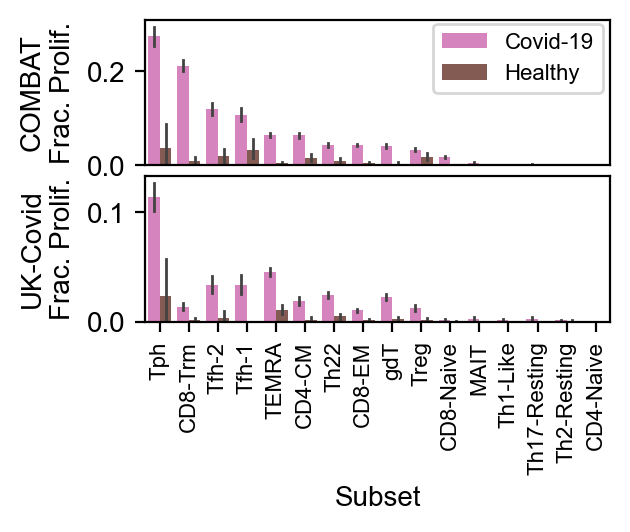

In [29]:
(fig,axes) = plt.subplots(2, 1, figsize=(3,2), dpi=200, gridspec_kw = {'hspace' : 0.07})

cmap = {'Covid-19': sns.color_palette("tab10")[6], 'Healthy':sns.color_palette("tab10")[5]}
for i, dataset in enumerate(['COMBAT', 'UK-Covid']):
    ax = axes[i]
    pct_prolif = results[dataset]
    # for j, pheno in enumerate(['Covid-19', 'Healthy']):
    sns.barplot(x='Lineage', y='Proliferating',
                ax=ax, order=lineage_order,
                palette=cmap, hue='Phenotype', errwidth=1,
                data=results[dataset])
        
        #ax.bar(x = lineage_order, height = pct_prolif.loc[lineage_order, pheno], label=pheno, color=cmap[pheno])
    
    
    if i == 1:
        ax.set_yticks([0, .1])

        ax.set_xlabel('Subset', fontsize=label_fontsize)
        ax.set_xticklabels(lineage_order, rotation=90, fontsize=tick_fontsize)
        ax.get_legend().remove()
    else:
        ax.set_xlabel('')
        ax.set_xticks([])
    
    ax.set_ylabel('%s\nFrac. Prolif.' % dataset, fontsize=label_fontsize)
        
axes[0].legend(fontsize=8, loc=(.62, .5))

plt.savefig(os.path.join(figdir, 'Barplot_PctProlifByLineage_UKCovidANDcombat.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'Barplot_PctProlifByLineage_UKCovidANDcombat.pdf'), bbox_inches="tight")